In [1]:
import torch
import torch.nn as nn
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import importlib
import student_transformer
importlib.reload(student_transformer)
from student_transformer import StudentTransformer
from data_loader import StudentPerformanceDataset, collate_fn
from torch.utils.data import DataLoader

# Константы
SEQ_LEN = 8
DEVICE = torch.device("cpu")
print(f"Используем устройство: {DEVICE}")


Используем устройство: cpu


In [2]:
dataset = StudentPerformanceDataset(db_path="school_main.db", seq_len=8)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

print(f"Количество последовательностей: {len(dataset)}")
print(f"Пример батча:")
for batch in dataloader:
    print("subject.shape:", batch["subject"].shape)
    print("numeric.shape:", batch["numeric"].shape)
    print("target.shape:", batch["target"].shape)
    break

✅ Загружено 73775 последовательностей (train)
Количество последовательностей: 73775
Пример батча:
subject.shape: torch.Size([32, 8])
numeric.shape: torch.Size([32, 8, 2])
target.shape: torch.Size([32])


In [ ]:
model = StudentTransformer(
    num_subjects=5,
    num_absence_reasons=6,   # ← обязательно 6!
    num_club_types=4,
    numeric_features=2,
    embed_dim=64,
    num_heads=4,
    num_layers=2,
    pred_type="binary"
)
device = torch.device("cpu")

model.to(device)
print("✅ Модель создана")
print("Число параметров:", sum(p.numel() for p in model.parameters()))

✅ Модель создана
Число параметров: 565697


In [8]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка данных
from data_loader import StudentPerformanceDataset, collate_fn
from torch.utils.data import DataLoader

train_dataset = StudentPerformanceDataset(split="train")
test_dataset = StudentPerformanceDataset(split="test")  # используем как val

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Настройка модели
device = torch.device("cpu")  # Или "cuda", если у вас есть доступ к GPU

model.to(device)

# Используем MSELoss (для задачи регрессии)
criterion = nn.MSELoss()  # Для регрессии
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Обучение
model.train()
train_losses = []
val_losses = []
val_metrics = []

print(f"{'Эпоха':<5} {'Train Loss':<10} {'Val Loss':<10} {'MAE':<7} {'MSE':<7} {'R2':<7} {'Время':<6}")
print("-" * 70)

for epoch in range(15):
    start_time = time.time()
    
    # --- Обучение ---
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch["target"])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- Валидация ---
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch)
            loss = criterion(outputs, batch["target"])
            val_loss += loss.item()
            
            # Собираем предсказания и реальные значения
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(batch["target"].cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Метрики для регрессии
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    # Сохраняем метрики
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_metrics.append({'mae': mae, 'mse': mse, 'r2': r2})
    
    # Вывод информации по эпохам
    epoch_time = time.time() - start_time
    print(f"{epoch+1:<5} {avg_train_loss:<10.4f} {avg_val_loss:<10.4f} "
          f"{mae:<7.4f} {mse:<7.4f} {r2:<7.4f} {epoch_time:<6.1f}s")

# Сохранение модели
torch.save(model.state_dict(), "student_transformer.pth")
print("\n✅ Модель сохранена")


✅ Загружено 229820 последовательностей (train)
✅ Загружено 54540 последовательностей (test)
Эпоха Train Loss Val Loss   MAE     MSE     R2      Время 
----------------------------------------------------------------------
1     0.2398     0.2492     0.3262  0.2493  0.4539  211.7 s
2     0.2389     0.2449     0.3231  0.2450  0.4634  210.5 s
3     0.2376     0.2467     0.3228  0.2468  0.4595  214.2 s
4     0.2375     0.2451     0.3270  0.2452  0.4630  157.8 s
5     0.2367     0.2462     0.3180  0.2463  0.4604  103.7 s
6     0.2369     0.2436     0.3151  0.2436  0.4663  99.1  s
7     0.2356     0.2427     0.3143  0.2428  0.4681  101.7 s
8     0.2351     0.2450     0.3223  0.2451  0.4632  99.0  s
9     0.2346     0.2421     0.3145  0.2422  0.4696  91.9  s
10    0.2348     0.2459     0.3091  0.2460  0.4611  91.9  s
11    0.2342     0.2407     0.3100  0.2408  0.4725  92.3  s
12    0.2339     0.2415     0.3120  0.2416  0.4708  93.0  s
13    0.2342     0.2439     0.3203  0.2440  0.4655  101.5 

In [9]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка тестовых данных
test_dataset = StudentPerformanceDataset(split="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Оценка
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(batch["target"].cpu().numpy())

# Метрики для регрессии
mae = mean_absolute_error(all_targets, all_preds)  # Средняя абсолютная ошибка
mse = mean_squared_error(all_targets, all_preds)  # Среднеквадратичная ошибка
r2 = r2_score(all_targets, all_preds)  # Коэффициент детерминации

# Вывод метрик
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

✅ Загружено 54540 последовательностей (test)
Mean Absolute Error (MAE): 0.3174
Mean Squared Error (MSE): 0.2430
R2 Score: 0.4677


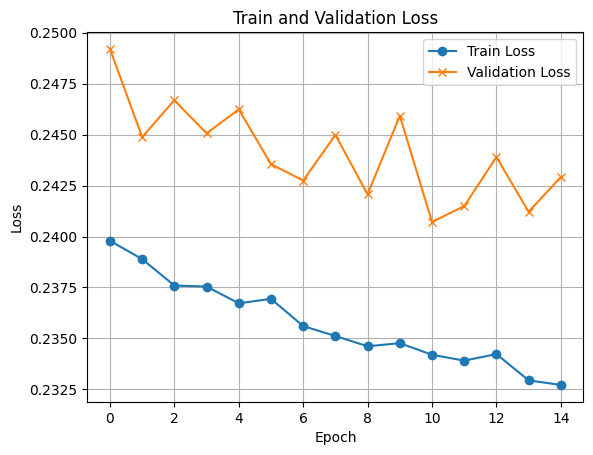

In [10]:
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Легенда, чтобы отличать train и validation
plt.grid(True)
plt.show()

In [13]:
# === Ячейка: Пример предсказания (инференс) ===

# 1. Загрузим сохранённую модель
model.load_state_dict(torch.load("student_transformer.pth", map_location=device))
model.eval()

# 2. Подготовим пример данных (8 недель по математике)
# Формат: [неделя 1, неделя 2, ..., неделя 8]
example_data = {
    "subject": "literature",
    "grades": [4.5, 4.0, 4.0, 3.5, 3.0, 3.0, 2.5, 3.0],        # оценки падают
    "attendance": [1, 1, 1, 0, 0, 1, 1, 1],                      # пропуски на 4-5 неделях
    "club_attended": [1, 1, 0, 0, 0, 0, 0, 0],                   # перестал ходить в кружок
    "absence_reasons": [None, None, None, "illness", "illness", None, None, None]
}

# 3. Преобразуем в формат модели
SUBJECT_TO_ID = {"math":0, "russian":1, "physics":2, "literature":3, "biology":4}
REASON_TO_ID = {None:0, "illness":1, "competition":2, "family":3, "other":4, "camp":5}

# Преобразование данных для модели
subject_id = SUBJECT_TO_ID[example_data["subject"]]
absence_ids = [REASON_TO_ID.get(r, 4) for r in example_data["absence_reasons"]]
numeric = np.stack([
    example_data["grades"],
    example_data["attendance"],
    example_data["club_attended"]
], axis=1).astype(np.float32)

# Создаём батч из одного примера
batch = {
    "subject": torch.tensor([[subject_id] * 8]),      # [1, 8] - данные для 8 недель
    "absence": torch.tensor([absence_ids]),           # [1, 8]
    "club": torch.tensor([example_data["club_attended"]]),  # [1, 8]
    "numeric": torch.tensor([numeric])                # [1, 8, 3] - оценки, посещаемость, кружки
}

# Предсказание
with torch.no_grad():
    prob = model({k: v.to(device) for k, v in batch.items()}).item()

# Вывод
print(f"🎓 Прогноз для ученика по предмету '{example_data['subject']}':")
print(f"   Вероятность снижения успеваемости: {prob:.2%}")
if prob > 0.5:
    print("   ⚠️ Рекомендуется педагогическое вмешательство!")
else:
    print("   ✅ Риск низкий.")

C:\Users\Stasy\AppData\Local\Temp\ipykernel_27592\1901443381.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  "numeric": torch.tensor([numeric])                # [1, 8, 3] - оценки, посещаемость, кружки


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x3 and 2x64)